## Load Packages and Extra Functions

In [1]:
using Printf, Distributions, OffsetArrays, FiniteDiff

#using FiniteDiff: finite_difference_derivative as derivative        #could do this instead

include("jlFiles/OptionsCalculations.jl")
include("jlFiles/printmat.jl")

printyellow (generic function with 1 method)

In [2]:
using Plots
#pyplot(size=(600,400))
gr(size=(480,320))
default(fmt = :svg)

# The Black-Scholes Model

The next cell calculates call `C` and put prices `P` from the Black-Scholes formula.

The key parameters are:
`(S,K,m,y,σ) = (current undelying price, strike price,time to expiration,interest rate, volatility)`

In [3]:
(S,K,m,y,σ) = (42,42,0.5,0.05,0.2)

C = OptionBlackSPs(S,K,m,y,σ)
printlnPs("call price at K=$K: ",C,"\n")

P = OptionBlackSPs(S,K,m,y,σ,0,true)
printlnPs("put price at K=$K:  ",P,"\n")

call price at K=42:      2.893          

put price at K=42:       1.856          



# Task 1

For a range of different prices of the underlying asset `S=30:60`, calculate the call and put prices and plot them (with `S` on the hoizontal axis).

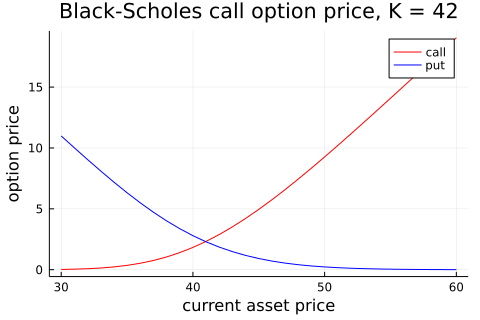

In [4]:
S_range   = range(30.0,60,step=1)                            #different spot prices
C_S_range = OptionBlackSPs.(S_range,K,m,y,σ)
P_S_range = OptionBlackSPs.(S_range,K,m,y,σ,0,true)

p1 = plot( S_range,[C_S_range P_S_range],
           linecolor = [:red :blue],
           label = ["call" "put"],
           title = "Black-Scholes call option price, K = $K",
           xlabel = "current asset price",
           ylabel = "option price" )
display(p1)

# The Binomial Option Pricing Model

The next cell contains functions to implement a binomial option pricing model for European style (exercise at expiration only) and American style (exercise any day) options. We use the CRR (Cox-Ross-Rubinstein) parameterisation.

The key parameters are the same as before, but also `n` which is the number of time steps used in the calculations (which defaults to 250).

In [5]:
"""
CRRparams(σ,m,n,y)

    BOPM parameters according to CRR
"""
function CRRparams(σ,m,y,n)
    h = m/n                 #time step size (in years)
    u = exp(σ*sqrt(h))      #up move
    d = exp(-σ*sqrt(h))     #down move
    p = (exp(y*h) - d)/(u-d) #rn prob of up move
    return h,u,d,p
end    

function BOPM_European(S,K,m,y,σ,isPut=false,n=250)
    (h,u,d,p) = CRRparams(σ,m,y,n)
    STree     = BuildSTree(S,n,u,d)
    price     = EuOptionPrice(STree,K,y,h,p,isPut)[0][]
    return price
end

function BOPM_American(S,K,m,y,σ,isPut=false,n=250)
    (h,u,d,p) = CRRparams(σ,m,y,n)
    STree     = BuildSTree(S,n,u,d)
    price     = AmOptionPrice(STree,K,y,h,p,isPut)[1][0][1]
    return price
end

BOPM_American (generic function with 3 methods)

In [6]:
c_e = BOPM_European(S,K,m,y,σ,false)            #call price, European style
p_e = BOPM_European(S,K,m,y,σ,true)             #put price, European

c_a = BOPM_American(S,K,m,y,σ,false)            #call, American
p_a = BOPM_American(S,K,m,y,σ,true)             #put, American

printmat([c_e,p_e,c_a,p_a],rowNames=["call (Eu)","put (Eu)","call (Am)","put (Am)"])

printred("Notice that c_e=c_a but that p_a>=p_e")

call (Eu)     2.891
put (Eu)      1.854
call (Am)     2.891
put (Am)      1.954

Notice that c_e=c_a but that p_a>=p_e


# Task 2

Redo the calculation of p_e and p_a for `S=30:60` and plot the prices.

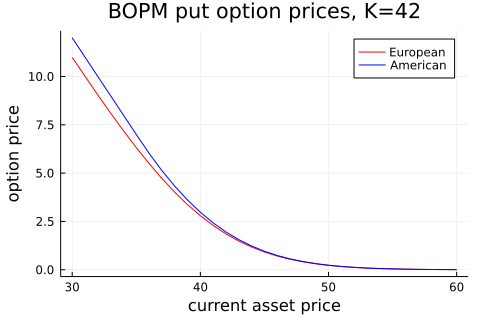

In [7]:
p_e = BOPM_European.(S_range,K,m,y,σ,true)
p_a = BOPM_American.(S_range,K,m,y,σ,true)

p1 = plot( S_range,[p_e p_a],
           linecolor = [:red :blue],
           label = ["European" "American"],
           title = "BOPM put option prices, K=$K",
           xlabel = "current asset price",
           ylabel = "option price" )
display(p1)

# Delta

To hedge an option contract (eg. if we are short one option contract), we buy $\Delta$ units of the underlying asset, where $\Delta$ is the partial derivative of the option price with respect to the price of the underlying asset.

Calculate $\Delta$ for both the European and American puts, using the BOPM function. Do the calculation for each value in `S_range` and plot the results.

To calculate the derivatives we use 
`FiniteDiff.finite_difference_derivative(the function,an S value)`

In [8]:
L = length(S_range)
(Δp_e,Δp_a) = [fill(NaN,L) for _=1:2]
for i = 1:L
    Δp_e[i] = FiniteDiff.finite_difference_derivative( z->BOPM_European(z,K,m,y,σ,true),S_range[i] )
    Δp_a[i] = FiniteDiff.finite_difference_derivative( z->BOPM_American(z,K,m,y,σ,true),S_range[i] )
end

                          #this would also work, no need for a loop
 #FiniteDiff.finite_difference_derivative( z->BOPM_European.(z,K,m,y,σ,true),S_range,Val{:central} )

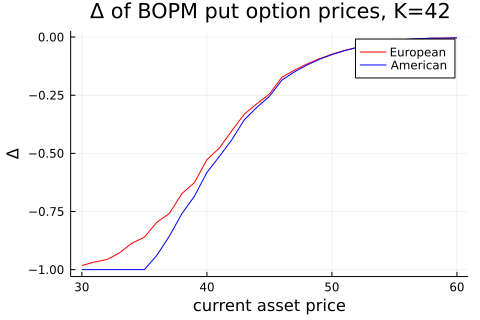

In [9]:
p1 = plot( S_range,[Δp_e Δp_a],
           linecolor = [:red :blue],
           label = ["European" "American"],
           title = "Δ of BOPM put option prices, K=$K",
           xlabel = "current asset price",
           ylabel = "Δ" )
display(p1)